In [4]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
# Load dataset
ratings_path = "ml-latest-small/ratings.csv"
ratings = pd.read_csv(ratings_path)

In [6]:
# Identify actual min and max ratings
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()
print(f"Min rating: {min_rating}, Max rating: {max_rating}")

Min rating: 0.5, Max rating: 5.0


In [7]:
# Normalize ratings based on actual range
ratings['normalized_rating'] = ratings['rating'].apply(
    lambda x: (x - min_rating) / (max_rating - min_rating) if x > 0 else 0
)

In [8]:
# Map userId and movieId to consecutive indices
user_mapping = {user_id: idx for idx, user_id in enumerate(ratings['userId'].unique())}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(ratings['movieId'].unique())}

ratings['userId'] = ratings['userId'].map(user_mapping)
ratings['movieId'] = ratings['movieId'].map(movie_mapping)

# Number of users and movies
num_users = len(user_mapping)
num_movies = len(movie_mapping)
print(f"Number of users: {num_users}")
print(f"Number of movies: {num_movies}")

Number of users: 610
Number of movies: 9724


In [9]:
# Create user-item interaction matrix
user_item_matrix = torch.zeros((num_users, num_movies))

# Populate user-item interaction matrix
for row in ratings.itertuples():
    user_item_matrix[row.userId, row.movieId] = row.normalized_rating

In [10]:
user_item_matrix

tensor([[0.7778, 0.7778, 0.7778,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4444, 0.3333, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5556, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 1.0000,  ..., 0.5556, 0.6667, 0.6667]])

In [11]:
# Split users into train/val and test groups
users = ratings['userId'].unique()
train_val_users, test_users = train_test_split(users, test_size=0.2, random_state=77)

# Create train/val and test dataframes based on the user split
train_val_data = ratings[ratings['userId'].isin(train_val_users)].reset_index(drop=True)
test_data = ratings[ratings['userId'].isin(test_users)].reset_index(drop=True)

print(f"Train/Val Data Size: {train_val_data.shape[0]}")
print(f"Test Data Size: {test_data.shape[0]}")

Train/Val Data Size: 82140
Test Data Size: 18696


In [12]:
# Train/Val Matrix: Only for train_val_users
train_val_matrix = torch.zeros((len(train_val_users), num_movies))

# Test Matrix: Only for test_users
test_matrix = torch.zeros((len(test_users), num_movies))

# Populate train/val and test matrices
train_val_user_mapping = {u: i for i, u in enumerate(train_val_users)}
test_user_mapping = {u: i for i, u in enumerate(test_users)}

for row in train_val_data.itertuples():
    user_idx = train_val_user_mapping[row.userId]
    train_val_matrix[user_idx, row.movieId] = row.normalized_rating

for row in test_data.itertuples():
    user_idx = test_user_mapping[row.userId]
    test_matrix[user_idx, row.movieId] = row.normalized_rating

print("Train/Val and Test matrices populated.")

Train/Val and Test matrices populated.


In [13]:
total_entries = num_users * num_movies

non_zero_entries = ratings.shape[0]

sparsity = (1 - (non_zero_entries / total_entries)) * 100

print(f"User-Item Matrix Sparsity: {sparsity:.2f}%")

User-Item Matrix Sparsity: 98.30%


# Data augmentation

Worsen's the performance, because data sparsity is 98+%

In [14]:
# def impute_with_item_averages(matrix):
#     # Compute average rating for each movie (ignoring zeros)
#     item_avg_ratings = torch.sum(matrix, dim=0) / (torch.sum(matrix > 0, dim=0) + 1e-8)

#     # Create a mask for missing ratings (zeros in the matrix)
#     missing_mask = matrix == 0

#     # Broadcast item_avg_ratings to the entire matrix and apply only to missing values
#     item_avg_matrix = item_avg_ratings.unsqueeze(0).expand_as(matrix)  # Expand to match matrix dimensions
#     matrix[missing_mask] = item_avg_matrix[missing_mask]  # Fill missing values with item averages

#     return matrix

# # Apply imputation to train_val_matrix and test_matrix
# train_val_matrix = impute_with_item_averages(train_val_matrix)
# test_matrix = impute_with_item_averages(test_matrix)


# # Final Matrix Shapes
# print(f"Train/Val Matrix Shape: {train_val_matrix.shape}")
# print(f"Test Matrix Shape: {test_matrix.shape}")

In [15]:
user_item_matrix.shape

torch.Size([610, 9724])

In [16]:
test_data

,userId,movieId,rating,timestamp,normalized_rating
0,2,259,0.5,1306463578,0.000000
1,2,28,0.5,1306464275,0.000000
2,2,260,0.5,1306463619,0.000000
3,2,261,0.5,1306464228,0.000000
4,2,262,0.5,1306463595,0.000000
...,...,...,...,...,...
18691,602,5359,1.0,1002403253,0.111111
18692,602,3322,1.0,1002403269,0.111111
18693,602,2122,4.0,1002403400,0.777778
18694,602,231,3.0,953926877,0.555556


In [17]:
train_matrix, val_matrix = train_test_split(train_val_matrix, test_size=0.2, random_state=78)

In [18]:
test_data.shape

(18696, 5)

In [19]:
train_val_matrix.shape

torch.Size([488, 9724])

In [20]:
test_matrix.shape

torch.Size([122, 9724])

In [21]:
val_matrix.shape

torch.Size([98, 9724])

In [22]:
class AutoRecSig(nn.Module):
    def __init__(self, num_items, hidden_dim, lambda_, p=0.2):
        super(AutoRecSig, self).__init__()
        self.lambda_ = lambda_
        self.encoder = nn.Linear(num_items, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, num_items, bias=True)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        encoded = self.dropout(self.sigmoid(self.encoder(x)))
        decoded = self.decoder(encoded)
        return decoded

    def regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += param.norm(2)
        return self.lambda_ * reg_loss

In [23]:
class AutoRecTan(nn.Module):
    def __init__(self, num_items, hidden_dim, lambda_, p=0.2):
        super(AutoRecTan, self).__init__()
        self.lambda_ = lambda_
        self.encoder = nn.Linear(num_items, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, num_items, bias=True)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        encoded = self.dropout(self.tanh(self.encoder(x)))
        decoded = self.decoder(encoded)
        return decoded

    def regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += param.norm(2)
        return self.lambda_ * reg_loss

In [24]:
class AutoRecRel(nn.Module):
    def __init__(self, num_items, hidden_dim, lambda_, p=0.2):
        super(AutoRecRel, self).__init__()
        self.lambda_ = lambda_
        self.encoder = nn.Linear(num_items, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, num_items, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        encoded = self.dropout(self.relu(self.encoder(x)))
        decoded = self.decoder(encoded)
        return decoded

    def regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += param.norm(2)
        return self.lambda_ * reg_loss

In [25]:
def train_epoch(model, train_data, optimizer, criterion, batch_size):
    model.train()
    num_batches = train_data.size(0) // batch_size
    total_loss = 0

    for i in range(num_batches):
        batch = train_data[i * batch_size:(i + 1) * batch_size].to(device)

        optimizer.zero_grad()
        predictions = model(batch)
        mask = batch > 0 
        loss = criterion(predictions[mask], batch[mask]) + model.regularization_loss()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / num_batches


In [26]:
def evaluate_model(model, test_data, criterion, batch_size):
    model.eval()
    num_batches = test_data.size(0) // batch_size
    total_loss = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = test_data[i * batch_size:(i + 1) * batch_size].to(device)

            predictions = model(batch)
            mask = batch > 0 
            loss = criterion(predictions[mask], batch[mask])
            total_loss += loss.item()

    return total_loss / num_batches

In [27]:
# Hyperparameters
hidden_dim = 50
lambda_ = 0.001
learning_rate = 0.001
batch_size = 32
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
# Initialize model, optimizer, and loss function
model = AutoRecSig(num_movies, hidden_dim, lambda_).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
criterion = nn.MSELoss()

In [29]:
train_tensor = train_matrix.to(device)
test_tensor = test_matrix.to(device)
val_tensor = val_matrix.to(device)

In [30]:
train_losses, val_losses = [], []

In [31]:
for epoch in range(epochs):
    train_loss = train_epoch(model, train_tensor, optimizer, criterion, batch_size)
    val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/50, Train Loss: 0.5280, Validation Loss: 0.3758
Epoch 2/50, Train Loss: 0.3642, Validation Loss: 0.2145
Epoch 3/50, Train Loss: 0.2448, Validation Loss: 0.1298
Epoch 4/50, Train Loss: 0.1774, Validation Loss: 0.0953
Epoch 5/50, Train Loss: 0.1424, Validation Loss: 0.0813
Epoch 6/50, Train Loss: 0.1272, Validation Loss: 0.0749
Epoch 7/50, Train Loss: 0.1153, Validation Loss: 0.0712
Epoch 8/50, Train Loss: 0.1086, Validation Loss: 0.0686
Epoch 9/50, Train Loss: 0.1017, Validation Loss: 0.0672
Epoch 10/50, Train Loss: 0.0944, Validation Loss: 0.0661
Epoch 11/50, Train Loss: 0.0903, Validation Loss: 0.0659
Epoch 12/50, Train Loss: 0.0848, Validation Loss: 0.0648
Epoch 13/50, Train Loss: 0.0816, Validation Loss: 0.0648
Epoch 14/50, Train Loss: 0.0797, Validation Loss: 0.0656
Epoch 15/50, Train Loss: 0.0773, Validation Loss: 0.0638
Epoch 16/50, Train Loss: 0.0744, Validation Loss: 0.0640
Epoch 17/50, Train Loss: 0.0725, Validation Loss: 0.0638
Epoch 18/50, Train Loss: 0.0697, Validat

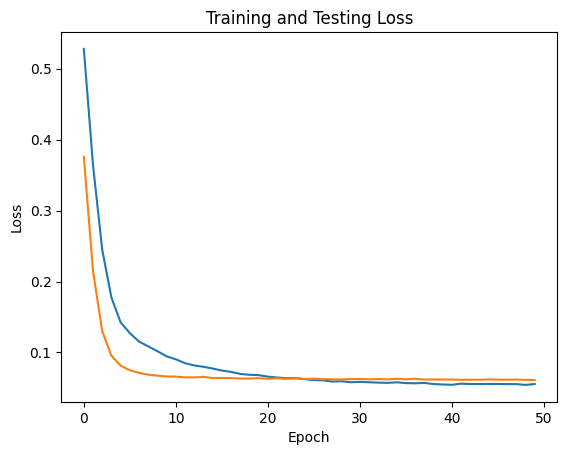

In [32]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.show()

In [33]:
def calculate_rmse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return np.sqrt(mse / total_ratings)

In [34]:
rmse = calculate_rmse(model, test_tensor, batch_size)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.2678


In [35]:
import numpy as np
import torch
from torch import nn

# Calculate RMSE
def calculate_rmse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return np.sqrt(mse / total_ratings)

# Calculate MAE
def calculate_mae(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mae = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mae += (predictions[mask] - batch[mask]).abs().sum().item()
            total_ratings += mask.sum().item()

    return mae / total_ratings

# Calculate MSE
def calculate_mse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return mse / total_ratings

# Calculate R-Squared
def calculate_r2(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    ss_total = 0
    ss_residual = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0

            mean_rating = batch[mask].mean().item()
            ss_total += ((batch[mask] - mean_rating) ** 2).sum().item()
            ss_residual += ((predictions[mask] - batch[mask]) ** 2).sum().item()

    return 1 - (ss_residual / ss_total)

# Calculate Explained Variance
def calculate_explained_variance(model, data, batch_size):
    model.eval()
    variance_explained = 0
    variance_total = 0

    with torch.no_grad():
        for i in range(data.size(0) // batch_size):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0

            batch_var = ((batch[mask] - batch[mask].mean()) ** 2).sum().item()
            residual_var = ((batch[mask] - predictions[mask]) ** 2).sum().item()

            variance_total += batch_var
            variance_explained += (batch_var - residual_var)

    return variance_explained / variance_total

In [36]:
batch_size = 32

rmse = calculate_rmse(model, test_tensor, batch_size)
mae = calculate_mae(model, test_tensor, batch_size)
mse = calculate_mse(model, test_tensor, batch_size)
r2 = calculate_r2(model, test_tensor, batch_size)
explained_variance = calculate_explained_variance(model, test_tensor, batch_size)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")
print(f"Test Explained Variance: {explained_variance:.4f}")

Test RMSE: 0.2678
Test MAE: 0.1978
Test MSE: 0.0717
Test R2: -0.5740
Test Explained Variance: -0.5740


In [37]:
import math
import torch

def evaluate_metrics(model, test_matrix, test_user_mapping, k=10, device="cpu"):
    hr, ndcg, precision, recall, mrr = 0, 0, 0, 0, 0
    total_users = 0

    model.eval()  # Ensure the model is in evaluation mode
    with torch.no_grad():
        for user_id, user_idx in test_user_mapping.items():
            # Get user interactions for the current user
            user_ratings = test_matrix[user_idx].to(device)
            ground_truth = torch.nonzero(user_ratings > 0, as_tuple=True)[0].tolist()

            # Skip users with no ground truth
            if not ground_truth:
                continue

            # Predict scores for all items
            predictions = model(user_ratings.unsqueeze(0)).squeeze(0).cpu()

            # Top-K predictions
            top_k = min(k, len(predictions))
            predicted_top_k = torch.argsort(predictions, descending=True)[:top_k].tolist()

            # Calculate hits
            hits = len(set(ground_truth) & set(predicted_top_k))

            # Update metrics
            hr += 1 if hits > 0 else 0  # Hit Ratio
            precision += hits / top_k  # Precision@K
            recall += hits / len(ground_truth)  # Recall@K

            # Compute NDCG
            dcg = sum(
                1 / math.log2(i + 2) if predicted_top_k[i] in ground_truth else 0
                for i in range(top_k)
            )
            idcg = sum(1 / math.log2(i + 2) for i in range(min(len(ground_truth), top_k)))
            ndcg += dcg / idcg if idcg > 0 else 0

            # Compute MRR
            for rank, item in enumerate(predicted_top_k):
                if item in ground_truth:
                    mrr += 1 / (rank + 1)
                    break

            total_users += 1

    # Handle cases where no users are evaluated
    if total_users == 0:
        return {"HR": 0, "NDCG": 0, "Precision": 0, "Recall": 0, "MRR": 0}

    # Compute averages and return results as percentages
    return {
        "HR": (hr / total_users) * 100,
        "NDCG": (ndcg / total_users) * 100,
        "Precision": (precision / total_users) * 100,
        "Recall": (recall / total_users) * 100,
        "MRR": (mrr / total_users) * 100,
    }


In [38]:
k = 10
metrics = evaluate_metrics(model, test_matrix, test_user_mapping, k=k)

print(f"Hit Ratio-{k}: {metrics['HR']:.2f}%")
print(f"NDCG-{k}: {metrics['NDCG']:.2f}%")
print(f"Precision-{k}: {metrics['Precision']:.2f}%")
print(f"Recall-{k}: {metrics['Recall']:.2f}%")
print(f"MRR: {metrics['MRR']:.2f}%")

Hit Ratio-10: 76.23%
NDCG-10: 16.98%
Precision-10: 18.93%
Recall-10: 3.05%
MRR: 25.62%


The model demonstrates strong candidate selection with a Hit Ratio-10 of 80.33%, indicating its effectiveness in recommending at least one relevant item for most users. However, a NDCG-10 of 20.41% and MRR of 25.85% suggest room for improvement in ranking relevant items higher within the top-10. While Precision-10 of 23.69% reflects moderate relevance in predictions, the low Recall-10 of 3.36% highlights limitations in covering all relevant items. Overall, the model performs well at identifying some relevant items but needs refinement in ranking and recall for better recommendation quality.

**Hit Ratio (HR):** Measures how often the true item appears in the Top-K list of recommendations. A higher hit ratio indicates a better model.

**Normalized Discounted Cumulative Gain (NDCG):** Takes into account the position of the relevant item in the ranking. Higher scores are given if relevant items appear higher in the list.

**Precision@K:** Measures the proportion of the Top-K recommendations that are relevant.

**Recall@K:** Measures the proportion of all relevant items that are included in the Top-K list.

**Mean Reciprocal Rank (MRR):** Measures the rank of the first relevant item, giving higher scores if it appears earlier in the list.

In [36]:
def print_top_k_movies_with_titles(ratings, user_mapping, movie_mapping, predictions, k, movies_path):
    """
    Print the top-k actual and predicted movies for each user with movie titles.

    Args:
        ratings: Original ratings dataframe.
        user_mapping: Dictionary mapping user IDs to internal IDs.
        movie_mapping: Dictionary mapping movie IDs to internal IDs.
        predictions: Predicted ratings matrix.
        k: Number of top movies to display.
        movies_path: Path to the 'movies.csv' file for fetching movie titles.
    """
    # Load movie titles
    movies = pd.read_csv(movies_path)
    reverse_movie_mapping = {v: k for k, v in movie_mapping.items()}
    movie_id_to_title = {row['movieId']: row['title'] for _, row in movies.iterrows()}

    # Iterate through all users in the test set
    for user_id in range(predictions.shape[0]):
        # Get the actual top-k movies for the user
        actual_movies = ratings[ratings['userId'] == user_id].nlargest(k, 'rating')['movieId'].values
        # Map actual movie IDs to titles
        actual_titles = [movie_id_to_title.get(reverse_movie_mapping.get(movie), "Unknown") for movie in actual_movies]

        # Get the predicted top-k movies for the user
        predicted_scores = predictions[user_id].cpu().numpy()  # Convert tensor to numpy array
        top_k_indices = np.argsort(predicted_scores)[-k:][::-1]
        predicted_movies = [reverse_movie_mapping[idx] for idx in top_k_indices]
        # Map predicted movie IDs to titles
        predicted_titles = [movie_id_to_title.get(movie, "Unknown") for movie in predicted_movies]

        # Print results
        print(f"User {user_id + 1}:")
        print(f"  Actual Top Movies: {actual_titles}")
        print(f"  Predicted Top Movies: {predicted_titles}")
        print("----------------------------------------")


In [37]:
# Generate predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(test_matrix)

# Call the function to print top-K movies
print_top_k_movies_with_titles(ratings, user_mapping, movie_mapping, predictions, k=5,  movies_path='ml-latest-small/movies.csv')

User 1:
  Actual Top Movies: ['Seven (a.k.a. Se7en) (1995)', 'Usual Suspects, The (1995)', 'Bottle Rocket (1996)', 'Rob Roy (1995)', 'Canadian Bacon (1995)']
  Predicted Top Movies: ['Burnt by the Sun (Utomlyonnye solntsem) (1994)', 'Bridge on the River Kwai, The (1957)', 'Shawshank Redemption, The (1994)', 'Matrix, The (1999)', "Schindler's List (1993)"]
----------------------------------------
User 2:
  Actual Top Movies: ['Step Brothers (2008)', 'Inside Job (2010)', 'Warrior (2011)', 'Wolf of Wall Street, The (2013)', 'Mad Max: Fury Road (2015)']
  Predicted Top Movies: ['Burnt by the Sun (Utomlyonnye solntsem) (1994)', 'Bridge on the River Kwai, The (1957)', "Man Bites Dog (C'est arrivé près de chez vous) (1992)", 'Shawshank Redemption, The (1994)', 'Matrix, The (1999)']
----------------------------------------
User 3:
  Actual Top Movies: ['Escape from L.A. (1996)', 'Saturn 3 (1980)', 'Road Warrior, The (Mad Max 2) (1981)', 'The Lair of the White Worm (1988)', 'Hangar 18 (1980)']


# Choosing hyperparameters



In [49]:
# import itertools
# from sklearn.model_selection import KFold
# import numpy as np
# import torch
# from torch import nn

# # Define hyperparameter grid
# param_grid = {
#     'hidden_dim': [50, 100, 200],
#     'lambda_': [0.0001, 0.001, 0.01],
#     'learning_rate': [0.001, 0.0001, 0.00001],
#     'batch_size': [32, 64, 128],
# }

# param_combinations = list(itertools.product(*param_grid.values()))

# # Define K-Fold Cross-Validation
# k_folds = 5
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# # Function to train and evaluate using K-Fold Cross-Validation
# def train_and_evaluate_kfold(params, full_matrix, k_folds):
#     # Unpack parameters
#     hidden_dim, lambda_, learning_rate, batch_size= params

#     # Initialize storage for RMSE scores
#     fold_rmse_scores = []

#     # Perform K-Fold Cross-Validation
#     for train_idx, val_idx in kf.split(full_matrix):
#         # Create train and validation matrices
#         train_matrix = torch.zeros_like(full_matrix)
#         val_matrix = torch.zeros_like(full_matrix)
        
#         # Populate train and validation matrices
#         train_matrix[train_idx] = full_matrix[train_idx]
#         val_matrix[val_idx] = full_matrix[val_idx]
        
#         # Initialize model, optimizer, and loss function
#         model = AutoRecRel(num_movies, hidden_dim, lambda_).to(device)
#         optimizer = torch.optim.Adam(
#             model.parameters(),
#             lr=learning_rate,
#         )
#         criterion = nn.MSELoss()

#         # Train the model
#         train_tensor = train_matrix.to(device)
#         val_tensor = val_matrix.to(device)
#         for epoch in range(100):  # Fewer epochs for faster cross-validation
#             train_epoch(model, train_tensor, optimizer, criterion, batch_size)

#             # Evaluate the model on the validation set after each epoch
#             val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

#         # Final evaluation for this fold
#         rmse = calculate_rmse(model, val_tensor, batch_size)
#         fold_rmse_scores.append(rmse)

#     # Return the average RMSE across all folds
#     return np.mean(fold_rmse_scores)

# # Track best hyperparameters and performance
# best_params = None
# best_rmse = float('inf')

# # Perform hyperparameter search
# for i, params in enumerate(param_combinations):
#     print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
#     rmse = train_and_evaluate_kfold(params, user_item_matrix, k_folds)

#     print(f"Average RMSE across {k_folds} folds: {rmse:.4f}")

#     # Update best parameters if current RMSE is better
#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_params = params

# # Print the best hyperparameters
# best_param_dict = dict(zip(param_grid.keys(), best_params))
# print(f"\nRelU Best Hyperparameters: {best_param_dict}")
# print(f"Best RMSE: {best_rmse:.4f}")


Testing combination 1/81: (50, 0.0001, 0.001, 32)
Average RMSE across 5 folds: 0.2833
Testing combination 2/81: (50, 0.0001, 0.001, 64)
Average RMSE across 5 folds: 0.3032
Testing combination 3/81: (50, 0.0001, 0.001, 128)
Average RMSE across 5 folds: 0.3183
Testing combination 4/81: (50, 0.0001, 0.0001, 32)
Average RMSE across 5 folds: 0.4031
Testing combination 5/81: (50, 0.0001, 0.0001, 64)
Average RMSE across 5 folds: 0.4601
Testing combination 6/81: (50, 0.0001, 0.0001, 128)
Average RMSE across 5 folds: 0.4771
Testing combination 7/81: (50, 0.0001, 1e-05, 32)
Average RMSE across 5 folds: 0.5261
Testing combination 8/81: (50, 0.0001, 1e-05, 64)
Average RMSE across 5 folds: 0.6227
Testing combination 9/81: (50, 0.0001, 1e-05, 128)
Average RMSE across 5 folds: 0.6882
Testing combination 10/81: (50, 0.001, 0.001, 32)
Average RMSE across 5 folds: 0.2973
Testing combination 11/81: (50, 0.001, 0.001, 64)
Average RMSE across 5 folds: 0.3249
Testing combination 12/81: (50, 0.001, 0.001, 12

In [33]:
# import itertools
# from sklearn.model_selection import KFold
# import numpy as np
# import torch
# from torch import nn

# # Define hyperparameter grid
# param_grid = {
#     'hidden_dim': [50, 100, 200],
#     'lambda_': [0.0001, 0.001, 0.01],
#     'learning_rate': [0.001, 0.0001, 0.00001],
#     'batch_size': [32, 64, 128],
# }

# param_combinations = list(itertools.product(*param_grid.values()))

# # Define K-Fold Cross-Validation
# k_folds = 5
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# # Function to train and evaluate using K-Fold Cross-Validation
# def train_and_evaluate_kfold(params, full_matrix, k_folds):
#     # Unpack parameters
#     hidden_dim, lambda_, learning_rate, batch_size= params

#     # Initialize storage for RMSE scores
#     fold_rmse_scores = []

#     # Perform K-Fold Cross-Validation
#     for train_idx, val_idx in kf.split(full_matrix):
#         # Create train and validation matrices
#         train_matrix = torch.zeros_like(full_matrix)
#         val_matrix = torch.zeros_like(full_matrix)
        
#         # Populate train and validation matrices
#         train_matrix[train_idx] = full_matrix[train_idx]
#         val_matrix[val_idx] = full_matrix[val_idx]
        
#         # Initialize model, optimizer, and loss function
#         model = AutoRecTan(num_movies, hidden_dim, lambda_).to(device)
#         optimizer = torch.optim.Adam(
#             model.parameters(),
#             lr=learning_rate,
#         )
#         criterion = nn.MSELoss()

#         # Train the model
#         train_tensor = train_matrix.to(device)
#         val_tensor = val_matrix.to(device)
#         for epoch in range(100):  # Fewer epochs for faster cross-validation
#             train_epoch(model, train_tensor, optimizer, criterion, batch_size)

#             # Evaluate the model on the validation set after each epoch
#             val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

#         # Final evaluation for this fold
#         rmse = calculate_rmse(model, val_tensor, batch_size)
#         fold_rmse_scores.append(rmse)

#     # Return the average RMSE across all folds
#     return np.mean(fold_rmse_scores)

# # Track best hyperparameters and performance
# best_params = None
# best_rmse = float('inf')

# # Perform hyperparameter search
# for i, params in enumerate(param_combinations):
#     print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
#     rmse = train_and_evaluate_kfold(params, user_item_matrix, k_folds)

#     print(f"Average RMSE across {k_folds} folds: {rmse:.4f}")

#     # Update best parameters if current RMSE is better
#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_params = params

# # Print the best hyperparameters
# best_param_dict = dict(zip(param_grid.keys(), best_params))
# print(f"\nTanh Best Hyperparameters: {best_param_dict}")
# print(f"Best RMSE: {best_rmse:.4f}")


Testing combination 1/81: (50, 0.0001, 0.001, 32)
Average RMSE across 5 folds: 0.2834
Testing combination 2/81: (50, 0.0001, 0.001, 64)
Average RMSE across 5 folds: 0.2988
Testing combination 3/81: (50, 0.0001, 0.001, 128)
Average RMSE across 5 folds: 0.3312
Testing combination 4/81: (50, 0.0001, 0.0001, 32)
Average RMSE across 5 folds: 0.3410
Testing combination 5/81: (50, 0.0001, 0.0001, 64)
Average RMSE across 5 folds: 0.3534
Testing combination 6/81: (50, 0.0001, 0.0001, 128)
Average RMSE across 5 folds: 0.3564
Testing combination 7/81: (50, 0.0001, 1e-05, 32)
Average RMSE across 5 folds: 0.4954
Testing combination 8/81: (50, 0.0001, 1e-05, 64)
Average RMSE across 5 folds: 0.5986
Testing combination 9/81: (50, 0.0001, 1e-05, 128)
Average RMSE across 5 folds: 0.6758
Testing combination 10/81: (50, 0.001, 0.001, 32)
Average RMSE across 5 folds: 0.2806
Testing combination 11/81: (50, 0.001, 0.001, 64)
Average RMSE across 5 folds: 0.2961
Testing combination 12/81: (50, 0.001, 0.001, 12

In [50]:
import itertools
from sklearn.model_selection import KFold
import numpy as np
import torch
from torch import nn

# Define hyperparameter grid
param_grid = {
    'hidden_dim': [50, 100, 200],
    'lambda_': [0.0001, 0.001, 0.01],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'batch_size': [32, 64, 128],
}

param_combinations = list(itertools.product(*param_grid.values()))

# Define K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Function to train and evaluate using K-Fold Cross-Validation
def train_and_evaluate_kfold(params, full_matrix, k_folds):
    # Unpack parameters
    hidden_dim, lambda_, learning_rate, batch_size= params

    # Initialize storage for RMSE scores
    fold_rmse_scores = []

    # Perform K-Fold Cross-Validation
    for train_idx, val_idx in kf.split(full_matrix):
        # Create train and validation matrices
        train_matrix = torch.zeros_like(full_matrix)
        val_matrix = torch.zeros_like(full_matrix)
        
        # Populate train and validation matrices
        train_matrix[train_idx] = full_matrix[train_idx]
        val_matrix[val_idx] = full_matrix[val_idx]
        
        # Initialize model, optimizer, and loss function
        model = AutoRecSig(num_movies, hidden_dim, lambda_).to(device)
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
        )
        criterion = nn.MSELoss()

        # Train the model
        train_tensor = train_matrix.to(device)
        val_tensor = val_matrix.to(device)
        for epoch in range(100):  # Fewer epochs for faster cross-validation
            train_epoch(model, train_tensor, optimizer, criterion, batch_size)

            # Evaluate the model on the validation set after each epoch
            val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

        # Final evaluation for this fold
        rmse = calculate_rmse(model, val_tensor, batch_size)
        fold_rmse_scores.append(rmse)

    # Return the average RMSE across all folds
    return np.mean(fold_rmse_scores)

# Track best hyperparameters and performance
best_params = None
best_rmse = float('inf')

# Perform hyperparameter search
for i, params in enumerate(param_combinations):
    print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
    rmse = train_and_evaluate_kfold(params, user_item_matrix, k_folds)

    print(f"Average RMSE across {k_folds} folds: {rmse:.4f}")

    # Update best parameters if current RMSE is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# Print the best hyperparameters
best_param_dict = dict(zip(param_grid.keys(), best_params))
print(f"\nSigmoid Best Hyperparameters: {best_param_dict}")
print(f"Best RMSE: {best_rmse:.4f}")


Testing combination 1/81: (50, 0.0001, 0.001, 32)
Average RMSE across 5 folds: 0.2520
Testing combination 2/81: (50, 0.0001, 0.001, 64)
Average RMSE across 5 folds: 0.2708
Testing combination 3/81: (50, 0.0001, 0.001, 128)
Average RMSE across 5 folds: 0.2738
Testing combination 4/81: (50, 0.0001, 0.0001, 32)
Average RMSE across 5 folds: 0.2453
Testing combination 5/81: (50, 0.0001, 0.0001, 64)
Average RMSE across 5 folds: 0.2509
Testing combination 6/81: (50, 0.0001, 0.0001, 128)
Average RMSE across 5 folds: 0.2960
Testing combination 7/81: (50, 0.0001, 1e-05, 32)
Average RMSE across 5 folds: 0.5252
Testing combination 8/81: (50, 0.0001, 1e-05, 64)
Average RMSE across 5 folds: 0.6361
Testing combination 9/81: (50, 0.0001, 1e-05, 128)
Average RMSE across 5 folds: 0.6970
Testing combination 10/81: (50, 0.001, 0.001, 32)
Average RMSE across 5 folds: 0.2425
Testing combination 11/81: (50, 0.001, 0.001, 64)
Average RMSE across 5 folds: 0.2452
Testing combination 12/81: (50, 0.001, 0.001, 12